In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
def plot_initial(ni,nj):
    u0=numpy.random.random((nj+1,ni+1))
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(0-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(0-dy/2,1+dy/2,nj+1)
    plot_3D(x,y,u0)

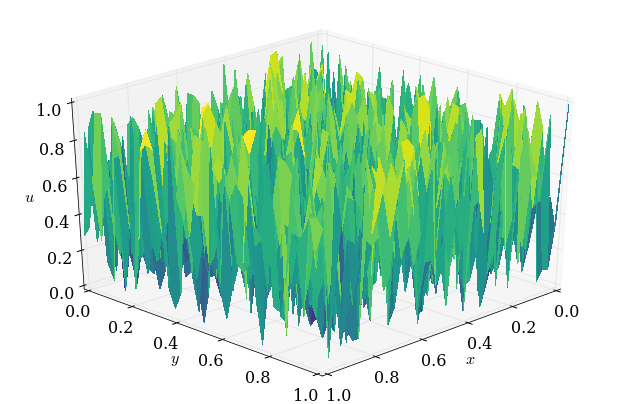

In [4]:
plot_initial(41,41)

In [5]:
@jit
def jacobi(ni,nj,n,res_target):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u_ex=numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    iterations=0
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj):
            for i in range(1,ni):
                if j==1 and i==1:
                    u[j,i]=1./(3*(dx**2+dy**2))*(uold[j,i+1]*dy**2+uold[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)
                elif j==1 and i==ni-1:
                    u[j,i]=1./(3*(dx**2+dy**2))*(uold[j,i-1]*dy**2+uold[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)
                elif j==nj-1 and i==1:
                    u[j,i]=1./(3*(dx**2+dy**2))*(uold[j,i+1]*dy**2+uold[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)
                elif j==nj-1 and i==ni-1:
                    u[j,i]=1./(3*(dx**2+dy**2))*(uold[j,i-1]*dy**2+uold[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)
                elif j==1:
                    u[j,i]=1./(3*dx**2+2*dy**2)*(uold[j+1,i]*dx**2+(uold[j,i+1]+uold[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)
                elif i==1:
                    u[j,i]=1./(2*dx**2+3*dy**2)*(uold[j,i+1]*dy**2+(uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
                elif j==nj-1:
                    u[j,i]=1./(3*dx**2+2*dy**2)*(uold[j-1,i]*dx**2+(uold[j,i+1]+uold[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)
                elif i==ni-1:
                    u[j,i]=1./(2*dx**2+3*dy**2)*(uold[j,i-1]*dy**2+(uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
                else:                
                    u[j,i]=1./(2*(dx**2+dy**2))*((uold[j,i+1]+uold[j,i-1])*dy**2+\
                          (uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
        u[0,:]=-u[1,:]
        u[-1,:]=-u[-2,:]
        u[:,0]=-u[:,1]
        u[:,-1]=-u[:,-2]
         
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        iterations+=1
                 
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
        
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

difference              error               residual           iterations
[1.5667155073284533e-13 0.0020460337182253152 9.995628769132736e-10 8460]


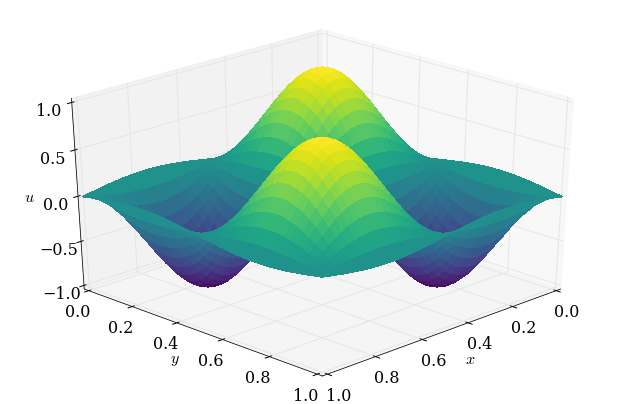

In [6]:
A40_jac1=jacobi(41,41,1,1e-9)
print('difference              error               residual           iterations')
print(A40_jac1[3:])
plot_3D(A40_jac1[1],A40_jac1[2],A40_jac1[0])

In [7]:
@jit
def SOR(ni,nj,n,res_target,omega):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u_ex=numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u0=numpy.random.random((nj+1,ni+1))
    u=u0.copy()
    
    dif=numpy.zeros((nj+1,ni+1))
    err=numpy.zeros((nj+1,ni+1))
    res=numpy.zeros((nj+1,ni+1))
    res_max=1e3
    iterations=0
    
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj):
            for i in range(1,ni):                
                if j==1 and i==1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i+1]*dy**2+u[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==1 and i==ni-1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i-1]*dy**2+u[j+1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1 and i==1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i+1]*dy**2+u[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1 and i==ni-1:
                    u[j,i]=omega/(3*(dx**2+dy**2))*\
                           (u[j,i-1]*dy**2+u[j-1,i]*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==1:
                    u[j,i]=omega/(3*dx**2+2*dy**2)*\
                           (u[j+1,i]*dx**2+(u[j,i+1]+u[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif i==1:
                    u[j,i]=omega/(2*dx**2+3*dy**2)*\
                           (u[j,i+1]*dy**2+(u[j+1,i]+u[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif j==nj-1:
                    u[j,i]=omega/(3*dx**2+2*dy**2)*\
                           (u[j-1,i]*dx**2+(u[j,i+1]+u[j,i-1])*dy**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                elif i==ni-1:
                    u[j,i]=omega/(2*dx**2+3*dy**2)*\
                           (u[j,i-1]*dy**2+(u[j+1,i]+u[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
                else:                
                    u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+(1-omega)*u[j,i]
        
        u[0,:]=-u[1,:] 
        u[-1,:]=-u[-2,:]
        u[:,0]=-u[:,1]
        u[:,-1]=-u[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        iterations+=1
        
    for j in range(nj+1):
        for i in range(ni+1):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
            
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

difference              error                  residual     iterations
[2.8851920852446256e-13 0.0020460337163500375 9.531517797256583e-10 299]


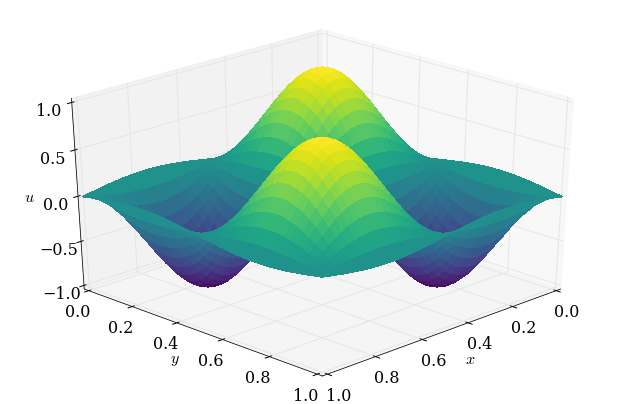

In [8]:
A40_SOR1=SOR(41,41,1,1e-9,1.9)
print('difference              error                  residual     iterations')
print(A40_SOR1[3:])
plot_3D(A40_SOR1[1],A40_SOR1[2],A40_SOR1[0])

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


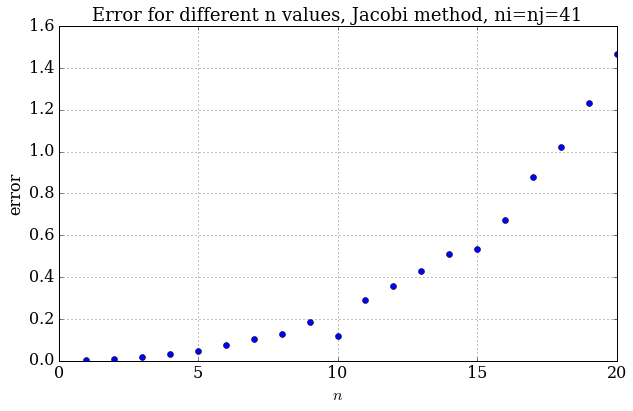

In [9]:
error40_jac_n=[]
for k in range(1,21):
    error40_jac_n.append(jacobi(41,41,k,1e-9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,20,20),error40_jac_n,'o')
pyplot.title('Error for different n values, Jacobi method, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


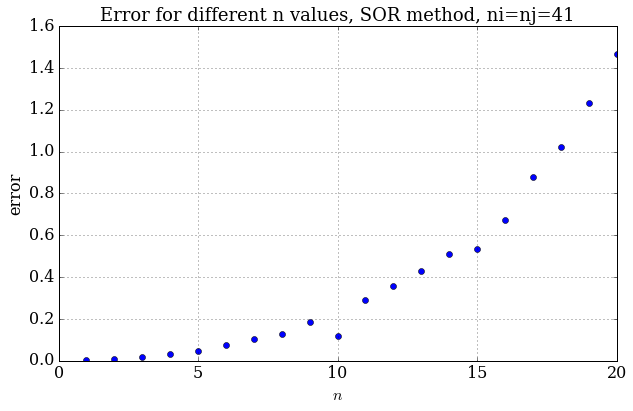

In [10]:
error40_SOR_n=[]
for k in range(1,21):
    error40_SOR_n.append(SOR(41,41,k,1e-9,1.9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,20,20),error40_SOR_n,'o')
pyplot.title('Error for different n values, SOR method, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


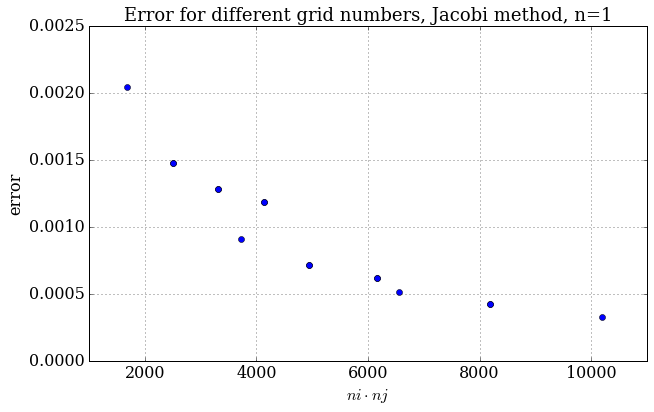

In [11]:
error_jac_grid=[]
ninj=[]
for ni in range(41,102,20):
    for nj in range(41,102,20):
        error_jac_grid.append(jacobi(ni,nj,1,1e-9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni \cdot nj$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_jac_grid,'o')
pyplot.title('Error for different grid numbers, Jacobi method, n=1',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


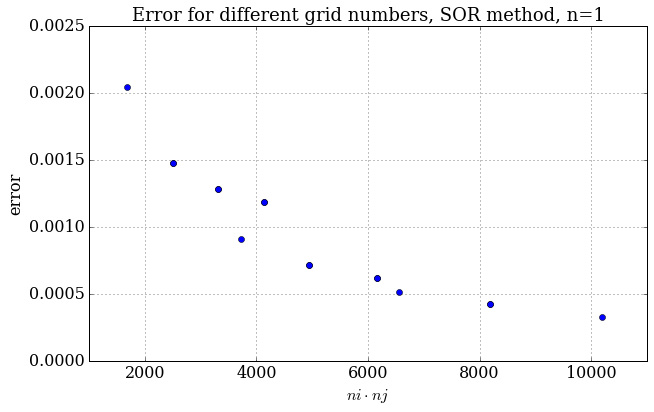

In [12]:
error_SOR_grid=[]
ninj=[]
for ni in range(41,102,20):
    for nj in range(41,102,20):
        error_SOR_grid.append(SOR(ni,nj,1,1e-9,1.9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni \cdot nj$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_SOR_grid,'o')
pyplot.title('Error for different grid numbers, SOR method, n=1',fontsize=18)
pyplot.legend()

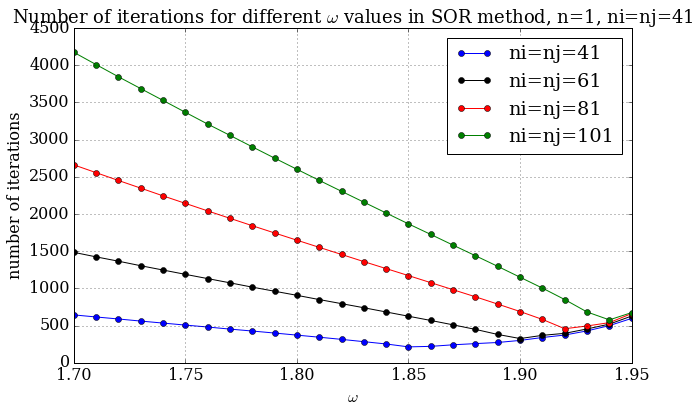

In [13]:
error40_SOR1_omega=[]
error60_SOR1_omega=[]
error80_SOR1_omega=[]
error100_SOR1_omega=[]
k=1.7
while k<1.96:
    error40_SOR1_omega.append(SOR(41,41,1,1e-9,k)[6])
    error60_SOR1_omega.append(SOR(61,61,1,1e-9,k)[6])
    error80_SOR1_omega.append(SOR(81,81,1,1e-9,k)[6])
    error100_SOR1_omega.append(SOR(101,101,1,1e-9,k)[6])
    k+=0.01
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$\omega$')
pyplot.ylabel('number of iterations')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error40_SOR1_omega,color='b',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error60_SOR1_omega,color='k',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error80_SOR1_omega,color='r',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error100_SOR1_omega,color='g',marker='o')
pyplot.title('Number of iterations for different $\omega$ values in SOR method, n=1, ni=nj=41',fontsize=18)
pyplot.legend(['ni=nj=41','ni=nj=61','ni=nj=81','ni=nj=101']);

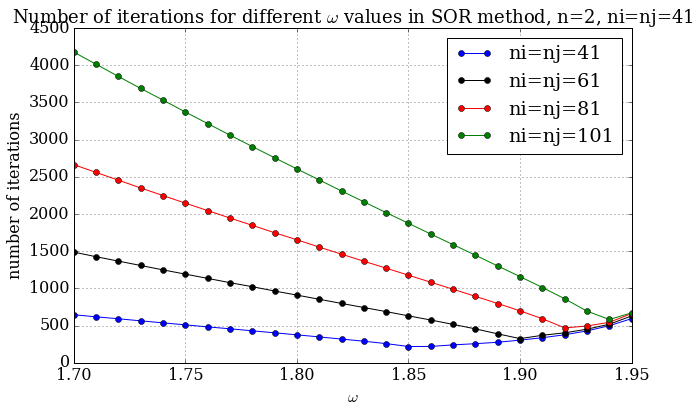

In [14]:
error40_SOR2_omega=[]
error60_SOR2_omega=[]
error80_SOR2_omega=[]
error100_SOR2_omega=[]
k=1.7
while k<1.96:
    error40_SOR2_omega.append(SOR(41,41,2,1e-9,k)[6])
    error60_SOR2_omega.append(SOR(61,61,2,1e-9,k)[6])
    error80_SOR2_omega.append(SOR(81,81,2,1e-9,k)[6])
    error100_SOR2_omega.append(SOR(101,101,2,1e-9,k)[6])
    k+=0.01
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$\omega$')
pyplot.ylabel('number of iterations')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error40_SOR2_omega,color='b',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error60_SOR2_omega,color='k',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error80_SOR2_omega,color='r',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error100_SOR2_omega,color='g',marker='o')
pyplot.title('Number of iterations for different $\omega$ values in SOR method, n=2, ni=nj=41',fontsize=18)
pyplot.legend(['ni=nj=41','ni=nj=61','ni=nj=81','ni=nj=101']);

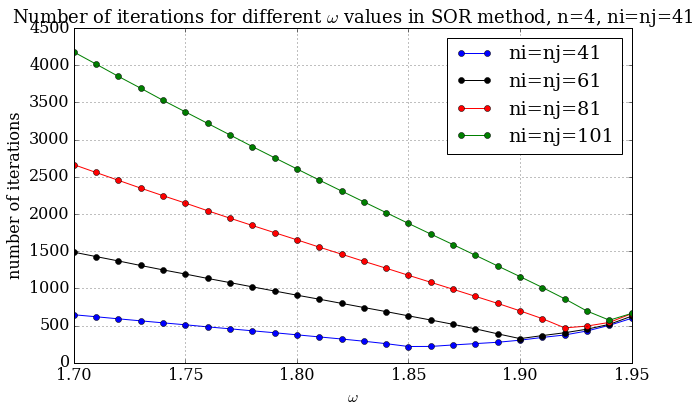

In [15]:
error40_SOR4_omega=[]
error60_SOR4_omega=[]
error80_SOR4_omega=[]
error100_SOR4_omega=[]
k=1.7
while k<1.96:
    error40_SOR4_omega.append(SOR(41,41,4,1e-9,k)[6])
    error60_SOR4_omega.append(SOR(61,61,4,1e-9,k)[6])
    error80_SOR4_omega.append(SOR(81,81,4,1e-9,k)[6])
    error100_SOR4_omega.append(SOR(101,101,4,1e-9,k)[6])
    k+=0.01
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$\omega$')
pyplot.ylabel('number of iterations')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error40_SOR4_omega,color='b',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error60_SOR4_omega,color='k',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error80_SOR4_omega,color='r',marker='o')
pyplot.plot(numpy.linspace(1.7,1.95,(1.95-1.7)/0.01+1),error100_SOR4_omega,color='g',marker='o')
pyplot.title('Number of iterations for different $\omega$ values in SOR method, n=4, ni=nj=41',fontsize=18)
pyplot.legend(['ni=nj=41','ni=nj=61','ni=nj=81','ni=nj=101']);